In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


def set_all_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
seed = 0
set_all_seed(seed=seed)

Using device: cuda


In [ ]:
# Paths
# TRAIN_DIR = './cosmic-curator/train_images'
# TEST_DIR = './cosmic-curator/test_images'
# TRAIN_CSV = './cosmic-curator/train2.csv'

TRAIN_DIR = '/kaggle/input/cosmic-curator/train_images/train_images'
TEST_DIR = '/kaggle/input/cosmic-curator/test_images/test_images'
TRAIN_CSV = '/kaggle/input/cosmic-curator/train2.csv'
OUT_DIR = './results'
if os.path.exists(OUT_DIR):
    import shutil
    shutil.rmtree(OUT_DIR)
# create directory
os.makedirs(OUT_DIR, exist_ok=True)
OUT_TRAIN_CSV = os.path.join(OUT_DIR, 'train.csv')
OUT_TEST_CSV = os.path.join(OUT_DIR, 'test.csv')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
# BATCH_SIZE = 32
BATCH_SIZE = 16
NUM_CLASSES = 3
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
IMG_SIZE = 424
VAL_SPLIT = 0.1
SAVE_CHECKPOINT = True

In [3]:
# --- Custom Dataset ---
class GalaxyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        asset_id = self.df.loc[idx, 'asset_id']
        img_path = os.path.join(self.img_dir, f"{asset_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, asset_id
        else:
            label = int(self.df.loc[idx, 'GalaxyType'])
            return image, label

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
# --- Load CSV ---
train_df = pd.read_csv(TRAIN_CSV)
print("Images in train set:", len(train_df))
# delete the images that are not in the train set
train_img_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TRAIN_DIR) if f.endswith('.jpg')]
train_df = train_df[train_df['asset_id'].isin(train_img_asset_ids)]
train_df = train_df.reset_index(drop=True)

test_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TEST_DIR) if f.endswith('.jpg')]
test_df = pd.DataFrame({'asset_id': test_asset_ids})
print("Images in test set:", len(test_df))


# --- Train/Val Split ---
train_df, val_df = train_test_split(train_df, test_size=VAL_SPLIT, stratify=train_df['GalaxyType'], random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("After splitting into train and val sets:")
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Images in train set: 912
Images in test set: 412
After splitting into train and val sets:
Train size: 727
Val size: 182
Test size: 412


In [5]:
train_dataset = GalaxyDataset(train_df, TRAIN_DIR, transform=train_transform)
val_dataset = GalaxyDataset(val_df, TRAIN_DIR, transform=test_transform)
test_dataset = GalaxyDataset(test_df, TEST_DIR, transform=test_transform, is_test=True)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset)) 
print("Test dataset size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train dataset size: 727
Validation dataset size: 182
Test dataset size: 412
Train loader size: 46
Validation loader size: 12
Test loader size: 26


In [6]:
# --- Model ---
model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [7]:
# --- Training Loop ---
# Initialize lists to store F1 scores
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []

best_val_f1 = 0.0  # To track the best validation F1 score
best_model_path = os.path.join(OUT_DIR, 'best_model.pth')

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_f1_scores.append(train_f1)
    train_losses.append(train_loss / len(train_loader))  # Average train loss

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_losses.append(val_loss / len(val_loader))  # Average validation loss

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train F1={train_f1:.4f}, Val Loss={val_losses[-1]:.4f}, Val F1={val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with Val F1={best_val_f1:.4f}")

    # Save checkpoint for each epoch if enabled
    if SAVE_CHECKPOINT and (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(OUT_DIR, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)

Epoch 1 [Val]: 100%|██████████| 12/12 [00:02<00:00,  5.68it/s]


Epoch 1: Train Loss=0.9281, Train F1=0.4852, Val Loss=0.9990, Val F1=0.3767
✅ Best model saved with Val F1=0.3767


Epoch 2 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.26it/s]


Epoch 2: Train Loss=0.8595, Train F1=0.4120, Val Loss=0.8804, Val F1=0.3246


Epoch 3 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.96it/s]


Epoch 3: Train Loss=0.7415, Train F1=0.5362, Val Loss=1.6581, Val F1=0.2349


Epoch 4 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.28it/s]


Epoch 4: Train Loss=0.7662, Train F1=0.5069, Val Loss=0.7685, Val F1=0.4116
✅ Best model saved with Val F1=0.4116


Epoch 5 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.70it/s]


Epoch 5: Train Loss=0.7011, Train F1=0.6142, Val Loss=0.9652, Val F1=0.4206
✅ Best model saved with Val F1=0.4206


Epoch 6 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.82it/s]


Epoch 6: Train Loss=0.7344, Train F1=0.5473, Val Loss=0.7764, Val F1=0.5724
✅ Best model saved with Val F1=0.5724


Epoch 7 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.09it/s]


Epoch 7: Train Loss=0.7058, Train F1=0.5849, Val Loss=0.8241, Val F1=0.6579
✅ Best model saved with Val F1=0.6579


Epoch 8 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.32it/s]


Epoch 8: Train Loss=0.7056, Train F1=0.6094, Val Loss=0.9003, Val F1=0.5051


Epoch 9 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 9: Train Loss=0.7378, Train F1=0.5861, Val Loss=1.0670, Val F1=0.3937


Epoch 10 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.30it/s]


Epoch 10: Train Loss=0.7134, Train F1=0.6034, Val Loss=1.0760, Val F1=0.3898


Epoch 11 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.73it/s]


Epoch 11: Train Loss=0.7093, Train F1=0.6379, Val Loss=6.9673, Val F1=0.2349


Epoch 12 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 12: Train Loss=0.7115, Train F1=0.6023, Val Loss=1.5745, Val F1=0.3770


Epoch 13 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]


Epoch 13: Train Loss=0.7041, Train F1=0.5990, Val Loss=1.2194, Val F1=0.3150


Epoch 14 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.76it/s]


Epoch 14: Train Loss=0.6844, Train F1=0.6366, Val Loss=1.2377, Val F1=0.4659


Epoch 15 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.13it/s]


Epoch 15: Train Loss=0.6466, Train F1=0.6563, Val Loss=0.6908, Val F1=0.5285


Epoch 16 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.59it/s]


Epoch 16: Train Loss=0.6470, Train F1=0.6629, Val Loss=0.6937, Val F1=0.6371


Epoch 17 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.08it/s]


Epoch 17: Train Loss=0.6741, Train F1=0.6231, Val Loss=0.8441, Val F1=0.5602


Epoch 18 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.87it/s]


Epoch 18: Train Loss=0.6659, Train F1=0.6358, Val Loss=0.7599, Val F1=0.5565


Epoch 19 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.00it/s]


Epoch 19: Train Loss=0.6767, Train F1=0.6635, Val Loss=1.1298, Val F1=0.4290


Epoch 20 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.47it/s]


Epoch 20: Train Loss=0.6538, Train F1=0.6086, Val Loss=0.7843, Val F1=0.6529


Epoch 21 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.95it/s]


Epoch 21: Train Loss=0.6757, Train F1=0.6415, Val Loss=0.8595, Val F1=0.6167


Epoch 22 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.86it/s]


Epoch 22: Train Loss=0.6672, Train F1=0.6528, Val Loss=0.7454, Val F1=0.6025


Epoch 23 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.77it/s]


Epoch 23: Train Loss=0.6472, Train F1=0.6577, Val Loss=0.8767, Val F1=0.5053


Epoch 24 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.72it/s]


Epoch 24: Train Loss=0.6279, Train F1=0.6770, Val Loss=0.7275, Val F1=0.5969


Epoch 25 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.46it/s]


Epoch 25: Train Loss=0.6386, Train F1=0.6662, Val Loss=1.0180, Val F1=0.3831


Epoch 26 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.68it/s]


Epoch 26: Train Loss=0.6576, Train F1=0.6338, Val Loss=0.7116, Val F1=0.6698
✅ Best model saved with Val F1=0.6698


Epoch 27 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.78it/s]


Epoch 27: Train Loss=0.6390, Train F1=0.6634, Val Loss=0.8495, Val F1=0.4586


Epoch 28 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.84it/s]


Epoch 28: Train Loss=0.6097, Train F1=0.6904, Val Loss=0.8275, Val F1=0.5860


Epoch 29 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.98it/s]


Epoch 29: Train Loss=0.6113, Train F1=0.6992, Val Loss=0.6706, Val F1=0.5313


Epoch 30 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.54it/s]


Epoch 30: Train Loss=0.6601, Train F1=0.6869, Val Loss=1.3723, Val F1=0.3607


Epoch 31 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.05it/s]


Epoch 31: Train Loss=0.6143, Train F1=0.6947, Val Loss=0.7209, Val F1=0.6350


Epoch 32 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s]


Epoch 32: Train Loss=0.6338, Train F1=0.6909, Val Loss=0.6453, Val F1=0.6907
✅ Best model saved with Val F1=0.6907


Epoch 33 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.01it/s]


Epoch 33: Train Loss=0.6290, Train F1=0.6802, Val Loss=0.7286, Val F1=0.4861


Epoch 34 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.51it/s]


Epoch 34: Train Loss=0.6191, Train F1=0.7187, Val Loss=0.6771, Val F1=0.6416


Epoch 35 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.03it/s]


Epoch 35: Train Loss=0.5787, Train F1=0.7263, Val Loss=0.7881, Val F1=0.4534


Epoch 36 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.31it/s]


Epoch 36: Train Loss=0.5976, Train F1=0.7106, Val Loss=0.7733, Val F1=0.6582


Epoch 37 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.67it/s]


Epoch 37: Train Loss=0.6174, Train F1=0.6976, Val Loss=0.9298, Val F1=0.6047


Epoch 38 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.57it/s]


Epoch 38: Train Loss=0.6133, Train F1=0.6685, Val Loss=0.6572, Val F1=0.6836


Epoch 39 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.06it/s]


Epoch 39: Train Loss=0.6109, Train F1=0.6701, Val Loss=0.9710, Val F1=0.4522


Epoch 40 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]


Epoch 40: Train Loss=0.6029, Train F1=0.6996, Val Loss=0.7487, Val F1=0.6618


Epoch 41 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.90it/s]


Epoch 41: Train Loss=0.5812, Train F1=0.7094, Val Loss=0.6619, Val F1=0.7238
✅ Best model saved with Val F1=0.7238


Epoch 42 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.63it/s]


Epoch 42: Train Loss=0.5923, Train F1=0.6959, Val Loss=2.4631, Val F1=0.2349


Epoch 43 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.53it/s]


Epoch 43: Train Loss=0.5832, Train F1=0.6896, Val Loss=0.8209, Val F1=0.5934


Epoch 44 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.75it/s]


Epoch 44: Train Loss=0.5739, Train F1=0.7218, Val Loss=0.6040, Val F1=0.6757


Epoch 45 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.71it/s]


Epoch 45: Train Loss=0.5656, Train F1=0.7183, Val Loss=0.7650, Val F1=0.5983


Epoch 46 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.52it/s]


Epoch 46: Train Loss=0.5573, Train F1=0.7302, Val Loss=0.5981, Val F1=0.7462
✅ Best model saved with Val F1=0.7462


Epoch 47 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.91it/s]


Epoch 47: Train Loss=0.5750, Train F1=0.7124, Val Loss=0.6287, Val F1=0.6056


Epoch 48 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.42it/s]


Epoch 48: Train Loss=0.5717, Train F1=0.6884, Val Loss=0.7547, Val F1=0.6256


Epoch 49 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.58it/s]


Epoch 49: Train Loss=0.5648, Train F1=0.7187, Val Loss=0.7337, Val F1=0.4861


Epoch 50 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.21it/s]

Epoch 50: Train Loss=0.5512, Train F1=0.7092, Val Loss=0.5743, Val F1=0.7134


In [9]:
# load best model
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3)
)
best_model_path = os.path.join(OUT_DIR, 'best_model.pth')
model.load_state_dict(torch.load(best_model_path))
model = model.to(DEVICE)

<ipython-input-9-0ce50f4d367e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


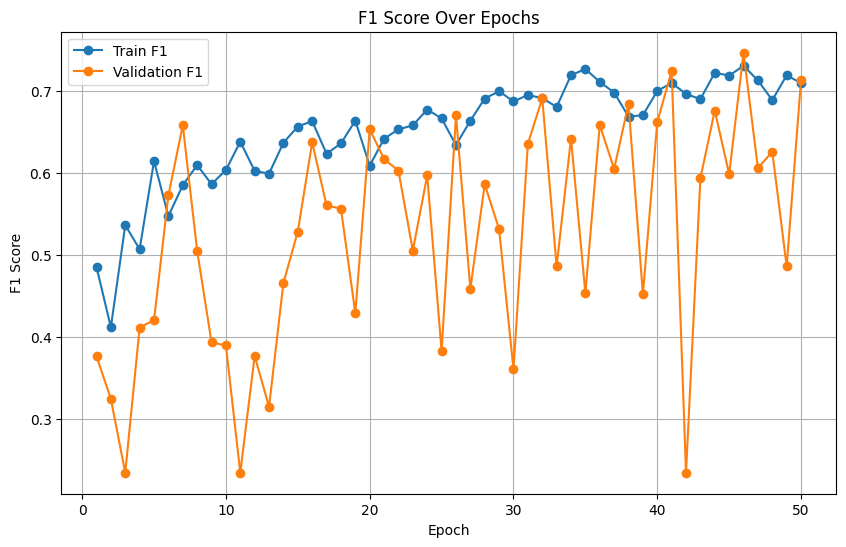

✅ F1 score plot saved at ./results/f1_scores_plot.png


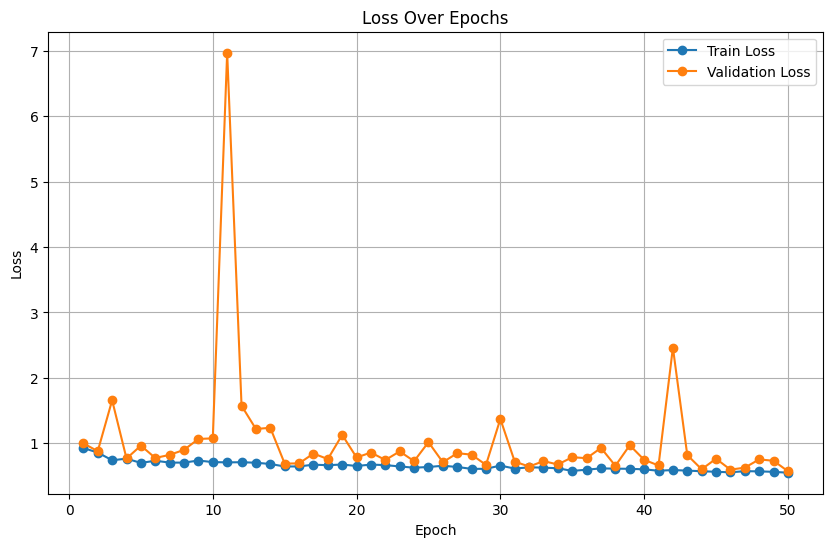

✅ Loss plot saved at ./results/losses_plot.png


In [10]:
# --- Plot F1 Scores ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, label='Train F1', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_f1_scores, label='Validation F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'f1_scores_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ F1 score plot saved at {plot_path}")

# --- Plot Losses ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'losses_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ Loss plot saved at {plot_path}")

In [11]:
# --- Test Prediction ---
model.eval()
predictions = []
asset_ids = []

with torch.no_grad():
    for images, ids in tqdm(test_loader, desc="Predicting"):
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)
        asset_ids.extend(ids.cpu().numpy())  # Convert tensor to numpy array and extend

# --- Save Submission ---
submission_df = pd.DataFrame({'id': asset_ids, 'GalaxyType': predictions})
submission_df.sort_values('id', inplace=True)
submission_df.to_csv(OUT_TEST_CSV, index=False)
print(f"Submission saved to {OUT_TEST_CSV}")
print(submission_df.head())


Predicting: 100%|██████████| 26/26 [00:04<00:00,  5.89it/s]

Submission saved to ./results/test.csv
     id  GalaxyType
133   1           2
398   2           2
348   3           2
336   4           2
35    5           2
